<a href="https://colab.research.google.com/github/zunayed-islam/CSE498R/blob/main/Another_copy_of_Optic_Disc_and_Exudates_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1>Notebook for Optic Disc Localization and detection of Exudates using the IDRID Segmentation dataset</H1>

[![dataset](https://img.shields.io/badge/Open_in_Colab-orange)](https://githubtocolab.com/Sohambasu07/DR_2021/blob/master/notebooks/Optic_Disc_and_Exudates_Detection.ipynb)
[![paper](https://img.shields.io/badge/Springer-Full_Paper-blue)](https://doi.org/10.1007/978-981-16-1543-6_16)
[![dataset](https://img.shields.io/badge/IDRID-Dataset-yellow)](https://ieee-dataport.org/open-access/indian-diabetic-retinopathy-image-dataset-idrid#files)

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import skimage
import time
import os
from skimage import data
from skimage import filters
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from skimage import io, morphology
from skimage.morphology import disk
from skimage.filters.rank import entropy
from sklearn.metrics import confusion_matrix

cv.__version__

'4.8.0'

In [ ]:
#Setting filepaths

template_path = '/content/template.jpg'  # Path to save generated template for OD localization
directory_path = '/content/images/'      # Path where images are stored
save_path = '/content/results/'          # Path to save OD localization results

if os.path.exists(save_path) is False:
  os.mkdir(save_path)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


True

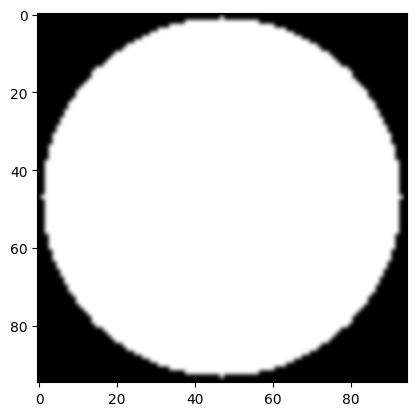

In [ ]:
#Template creation
template = np.ones((95,95), dtype="uint8") * 0
template = cv.circle(template, (47,47), 46, 255, -1)
print(template)
plt.imshow(template, cmap = 'gray', interpolation = 'bicubic')
cv.imwrite(template_path, template)

In [ ]:
def getImage(img_num):
    path = directory_path
    str_num = str(img_num).zfill(3)  # Use zfill to pad with zeros for consistency
    name_with_space = 'IDRiD_' + str_num + ' .jpg'
    name_without_space = 'IDRiD_' + str_num + '.jpg'
    full_path_with_space = path + name_with_space
    full_path_without_space = path + name_without_space

    # Try loading with space first, then without space if it fails
    image = cv.imread(full_path_with_space, -1)
    if image is None:
        image = cv.imread(full_path_without_space, -1)

    if image is None:
        print(f"Error: Could not load image {name_with_space} or {name_without_space}. Skipping...")
    else:
        print(f"Loaded image: {full_path_with_space if image is not None else full_path_without_space}")

    return image

In [ ]:
def imgResize(img):
  h = img.shape[0]
  w = img.shape[1]
  perc = 500/w
  w1 = 500
  h1 = int(h*perc)
  img_rs = cv.resize(img,(w1,h1))
  return img_rs

In [ ]:
def cannyEdges(img, th1, th2):
  edges = cv.Canny(img, th1, th2)
  return edges

In [ ]:
def kmeansclust(img, k, attempts, max_iter, acc, use = 'OD'):

  if use == 'OD':
    img_rsp = img.reshape((-1,1))
  else :
    img_rsp = img.reshape((-1,3))

  img_rsp = img_rsp.astype('float32')


  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, max_iter, acc)
  _, labels, (centers) = cv.kmeans(img_rsp, k, None, criteria, attempts, cv.KMEANS_RANDOM_CENTERS)
  centers = centers.astype('uint8')

  labels = labels.flatten()
  seg_img = centers[labels.flatten()]
  seg_img = seg_img.reshape(img.shape)
  return seg_img

In [ ]:
import os
print(os.listdir('/content/images/'))

['IDRiD_049.jpg', 'IDRiD_040.jpg', 'IDRiD_029.jpg', 'IDRiD_016.jpg', 'IDRiD_033.jpg', 'IDRiD_012.jpg', 'IDRiD_038.jpg', 'IDRiD_025.jpg', 'IDRiD_010.jpg', 'IDRiD_032.jpg', 'IDRiD_009.jpg', 'IDRiD_011.jpg', 'IDRiD_041.jpg', 'IDRiD_026.jpg', 'IDRiD_008.jpg', 'IDRiD_051.jpg', 'IDRiD_003.jpg', 'IDRiD_015.jpg', 'IDRiD_046.jpg', 'IDRiD_052.jpg', 'IDRiD_031.jpg', 'IDRiD_047.jpg', 'IDRiD_037.jpg', 'IDRiD_005.jpg', 'IDRiD_002.jpg', 'IDRiD_039.jpg', 'IDRiD_006.jpg', 'IDRiD_013.jpg', 'IDRiD_014.jpg', 'IDRiD_001.jpg', 'IDRiD_043.jpg', 'IDRiD_027.jpg', 'IDRiD_053.jpg', 'IDRiD_044.jpg', 'IDRiD_020.jpg', 'IDRiD_030.jpg', 'IDRiD_042.jpg', 'IDRiD_034.jpg', 'IDRiD_018.jpg', 'IDRiD_050.jpg', 'IDRiD_007.jpg', 'IDRiD_019.jpg', 'IDRiD_022.jpg', 'IDRiD_023.jpg', 'IDRiD_021.jpg', 'IDRiD_054.jpg', 'IDRiD_017.jpg', 'IDRiD_004.jpg', 'IDRiD_045.jpg', 'IDRiD_048.jpg', 'IDRiD_035.jpg', 'IDRiD_036.jpg', 'IDRiD_024.jpg', 'IDRiD_028.jpg']


Loaded image: /content/images/IDRiD_001 .jpg
Image Number:  1
318 200
Loaded image: /content/images/IDRiD_002 .jpg
Image Number:  2
111 138
Loaded image: /content/images/IDRiD_003 .jpg
Image Number:  3
107 138
Loaded image: /content/images/IDRiD_004 .jpg
Image Number:  4
147 146
Loaded image: /content/images/IDRiD_005 .jpg
Image Number:  5
108 135
Loaded image: /content/images/IDRiD_006 .jpg
Image Number:  6
77 153
Loaded image: /content/images/IDRiD_007 .jpg
Image Number:  7
365 147
Loaded image: /content/images/IDRiD_008 .jpg
Image Number:  8
109 102
Loaded image: /content/images/IDRiD_009 .jpg
Image Number:  9
355 129
Loaded image: /content/images/IDRiD_010 .jpg
Image Number:  10
288 169
Loaded image: /content/images/IDRiD_011 .jpg
Image Number:  11
214 219
Loaded image: /content/images/IDRiD_012 .jpg
Image Number:  12
194 217
Loaded image: /content/images/IDRiD_013 .jpg
Image Number:  13
306 160
Loaded image: /content/images/IDRiD_014 .jpg
Image Number:  14
344 188
Loaded image: /c

<ipython-input-124-17c4b066a4bc>:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(img_num)


280 166
Loaded image: /content/images/IDRiD_023 .jpg
Image Number:  23
382 161
Loaded image: /content/images/IDRiD_024 .jpg
Image Number:  24
102 135
Loaded image: /content/images/IDRiD_025 .jpg
Image Number:  25
353 137
Loaded image: /content/images/IDRiD_026 .jpg
Image Number:  26
127 132
Loaded image: /content/images/IDRiD_027 .jpg
Image Number:  27
369 154
Loaded image: /content/images/IDRiD_028 .jpg
Image Number:  28
90 149
Loaded image: /content/images/IDRiD_029 .jpg
Image Number:  29
348 185
Loaded image: /content/images/IDRiD_030 .jpg
Image Number:  30
116 148
Loaded image: /content/images/IDRiD_031 .jpg
Image Number:  31
306 167
Loaded image: /content/images/IDRiD_032 .jpg
Image Number:  32
106 138
Loaded image: /content/images/IDRiD_033 .jpg
Image Number:  33
363 169
Loaded image: /content/images/IDRiD_034 .jpg
Image Number:  34
82 122
Loaded image: /content/images/IDRiD_035 .jpg
Image Number:  35
378 202
Loaded image: /content/images/IDRiD_036 .jpg
Image Number:  36
123 172


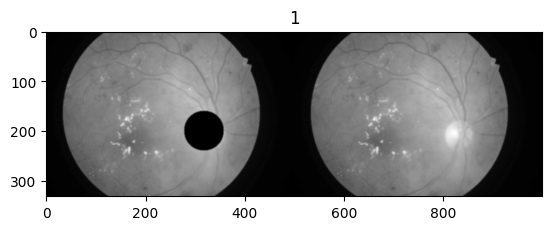

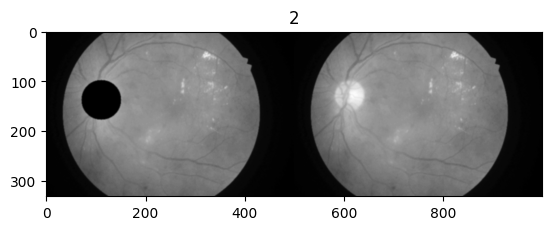

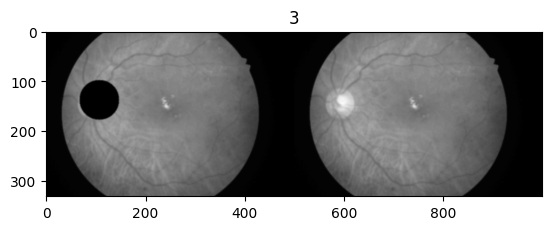

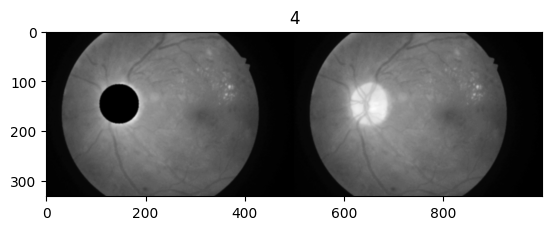

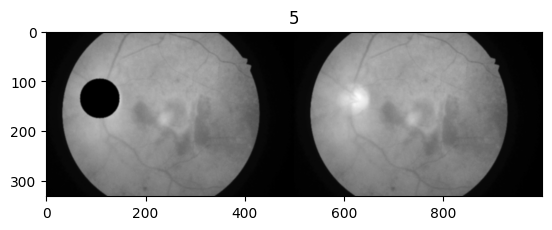

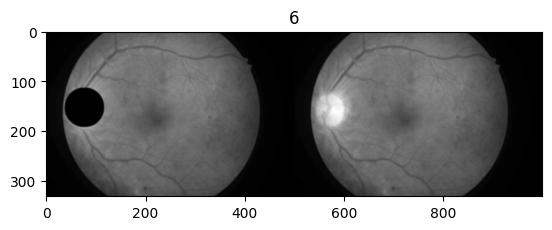

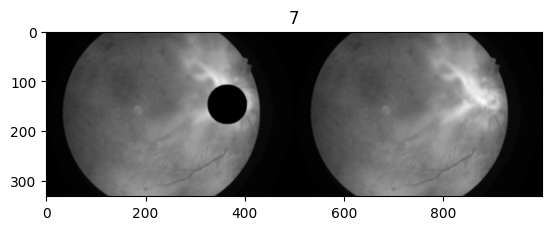

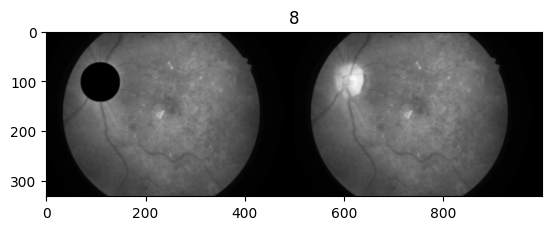

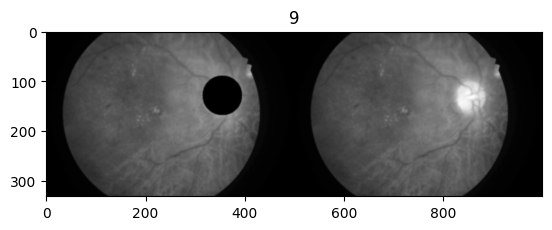

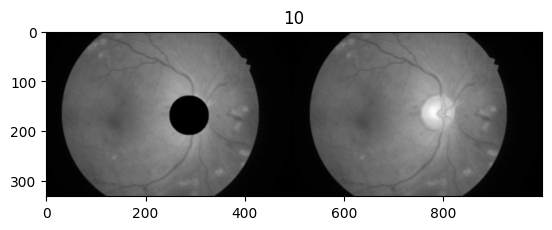

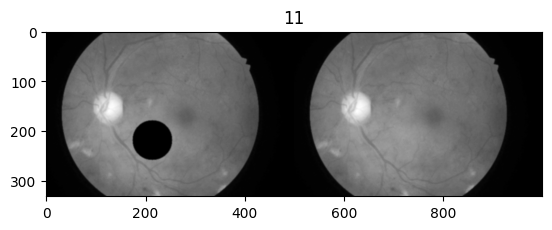

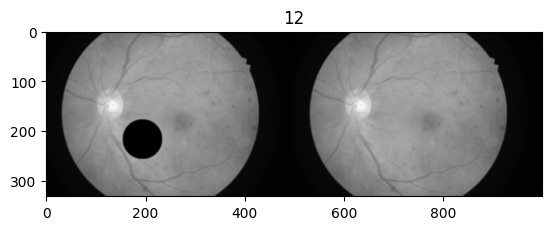

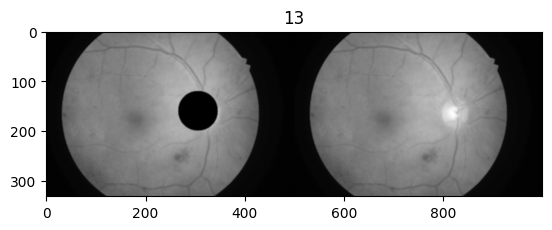

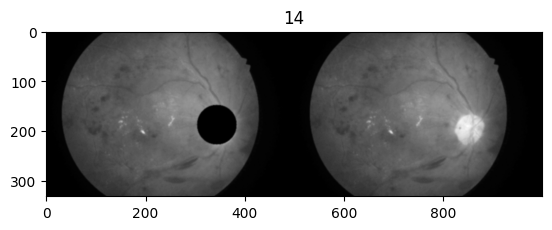

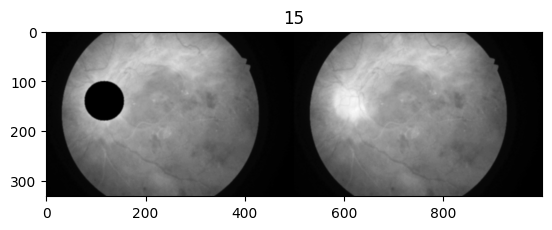

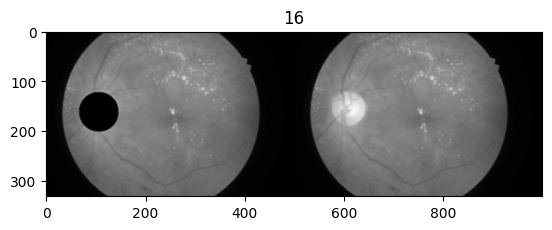

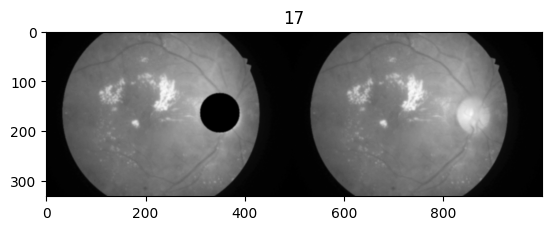

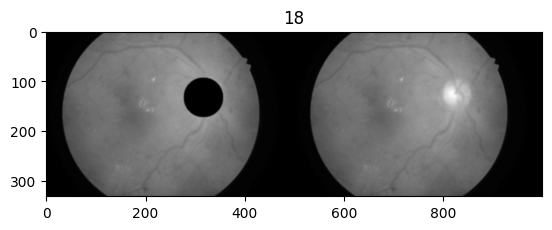

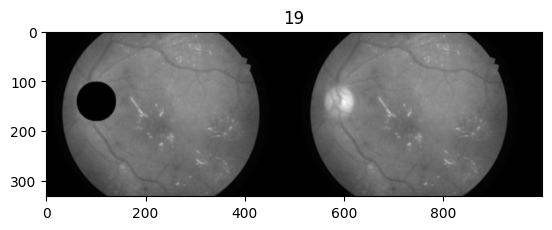

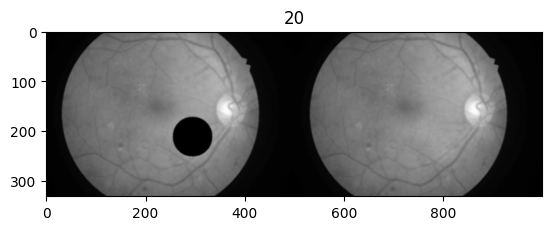

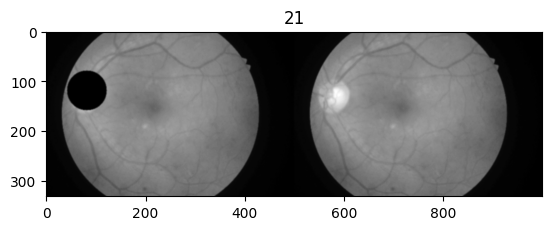

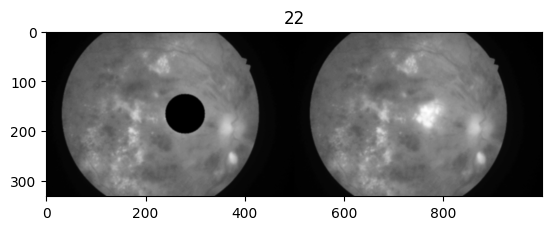

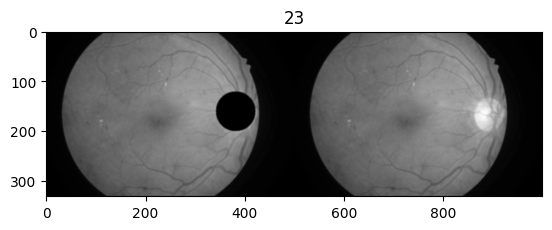

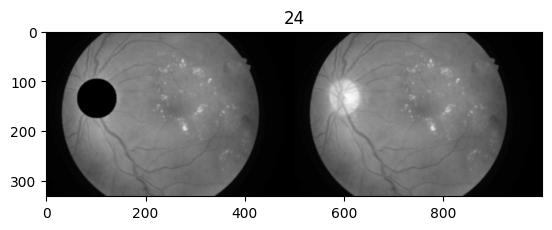

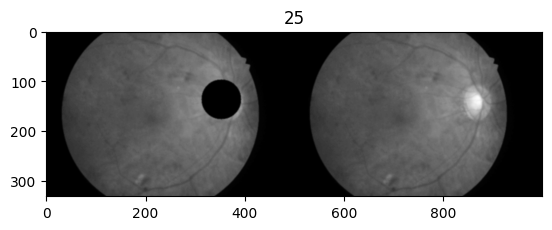

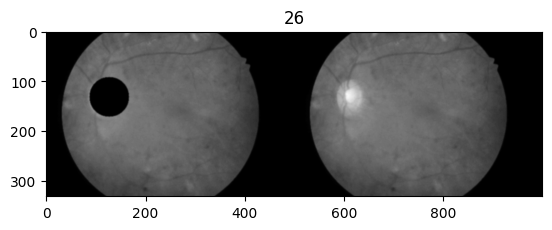

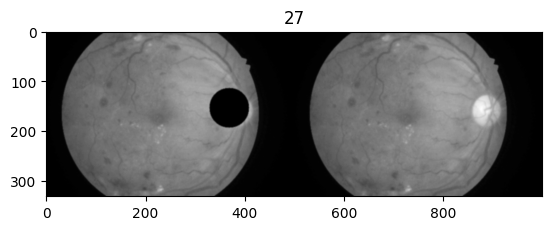

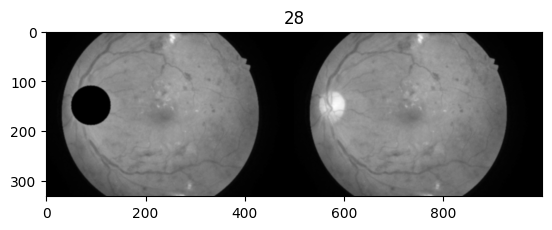

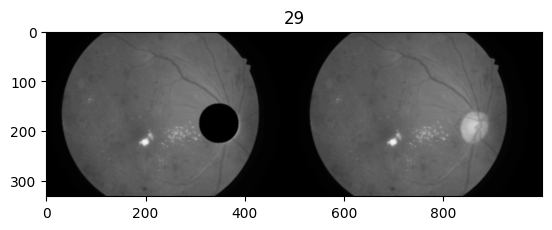

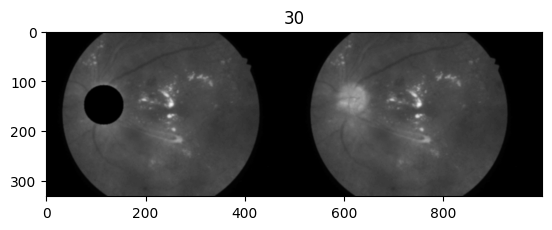

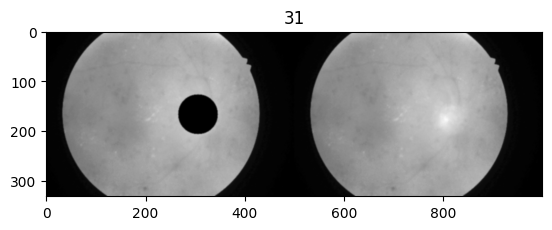

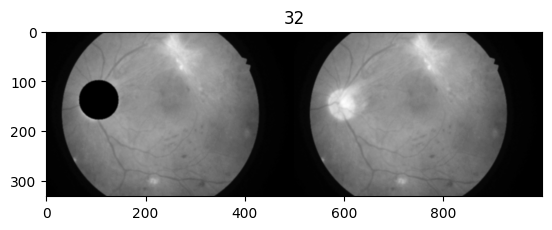

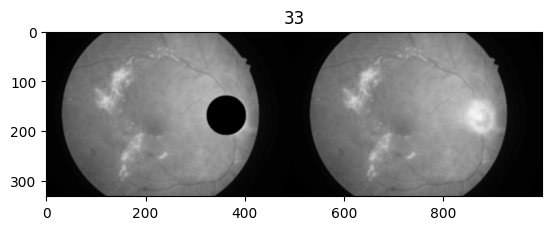

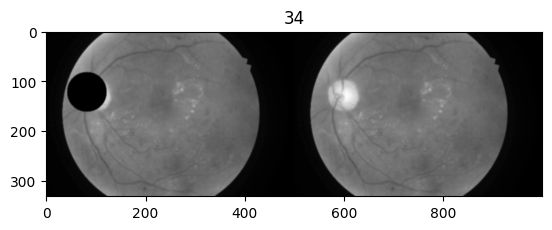

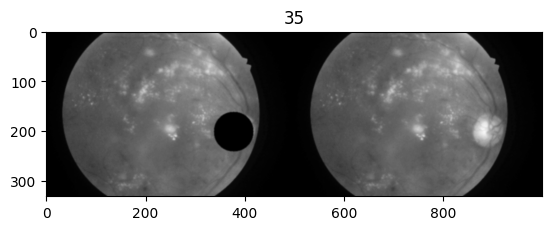

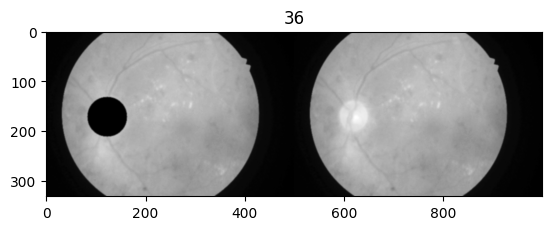

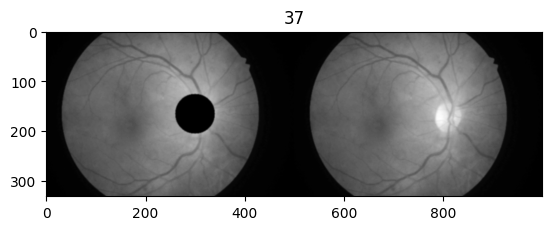

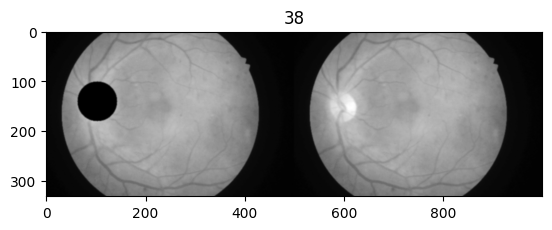

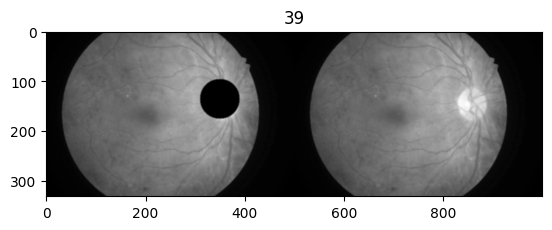

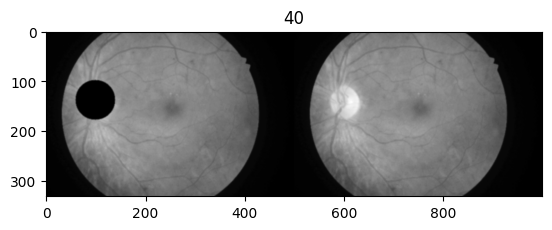

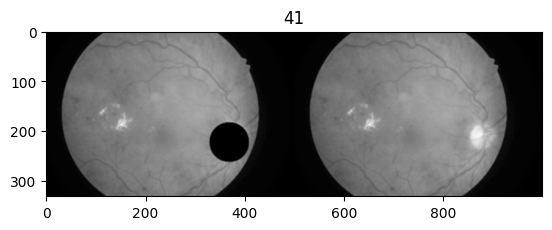

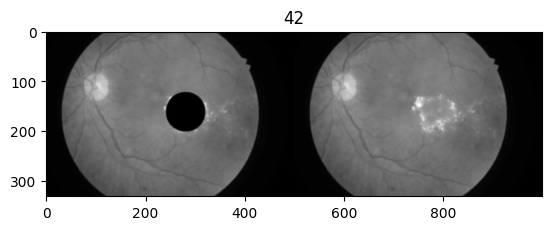

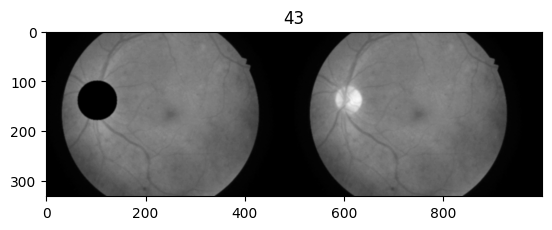

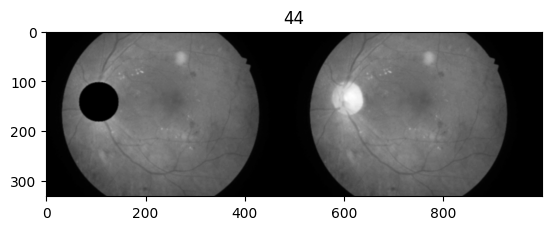

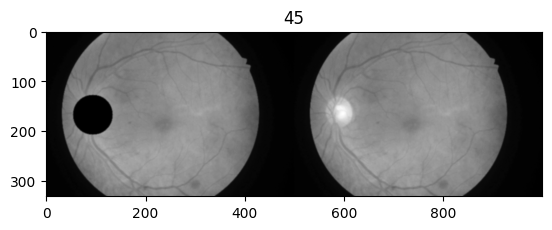

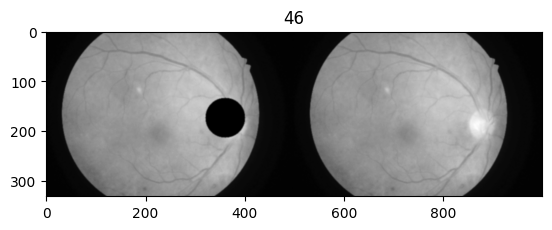

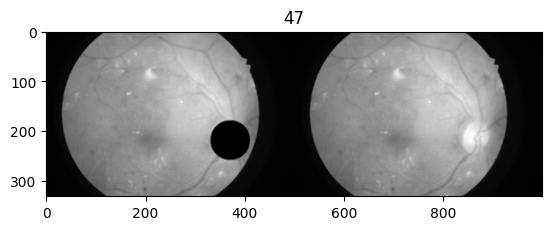

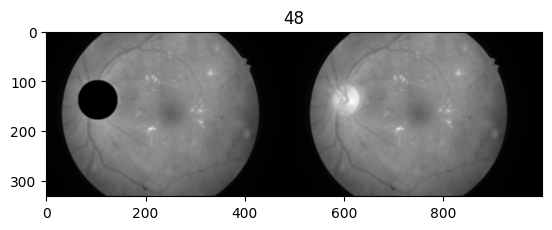

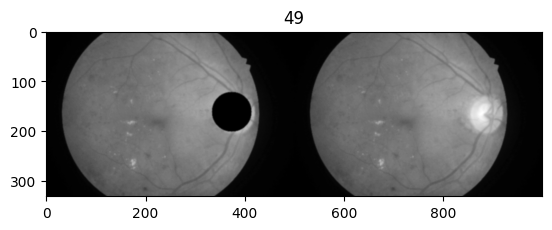

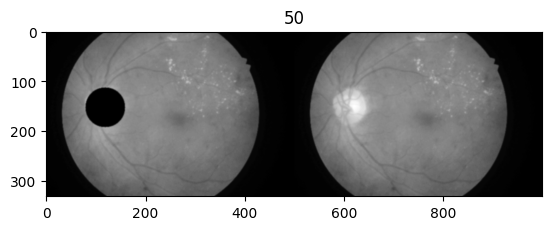

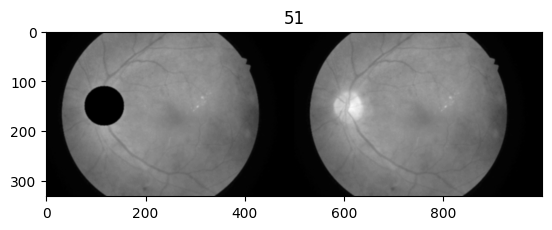

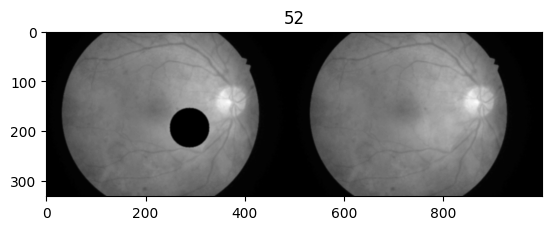

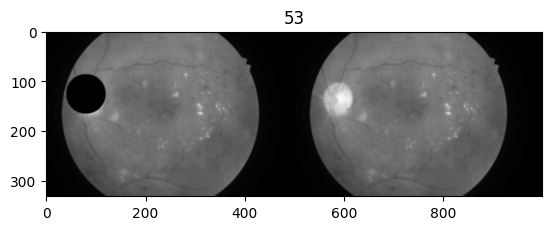

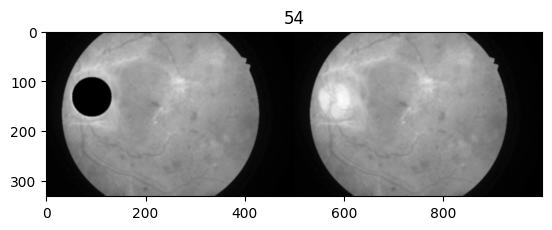

In [ ]:
#Optic Disc Localization

i = 0
count = 0
start_time = time.time()

for img_num in range(1,55):
  img = getImage(img_num)  # Check if getImage returns a valid image
  if img is None:
    print(f"Error: Could not load image number {img_num}. Skipping...")
    continue  # Skip to the next image if loading fails

  print("Image Number: ", img_num)

  img_rs = imgResize(img)

  img_grey = cv.cvtColor(img_rs, cv.COLOR_BGR2GRAY)


  img_k = kmeansclust(img_grey, 7, 10, 400, 0.99)


  temp = cv.imread(template_path, -1)


  #TEMPLATE MATCHING
  metd = cv.TM_CCOEFF_NORMED
  temp_mat = cv.matchTemplate(img_k, temp, metd)

  min_val, max_val, min_loc, max_loc = cv.minMaxLoc(temp_mat)
  x = max_loc[0]+45
  y = max_loc[1]+45
  print(x,y)



  temp_mat = img_grey.copy()
  img_mark = cv.circle(temp_mat, (x, y) ,40, 0, -1)

  if (img_num<10):
    img_path = save_path + "0" + str(img_num) +'.jpg'
  else:
    img_path = save_path + str(img_num) +'.jpg'
  cv.imwrite(img_path, img_mark)

  img_stack = np.hstack([img_mark, img_grey])

  plt.figure(img_num)
  plt.title(img_num)
  plt.imshow(img_stack, cmap = 'gray', interpolation = 'bicubic')



  i = i + 1

end_time = time.time()

In [ ]:
!ls /content/images/

IDRiD_001.jpg  IDRiD_010.jpg  IDRiD_019.jpg  IDRiD_028.jpg  IDRiD_037.jpg  IDRiD_046.jpg
IDRiD_002.jpg  IDRiD_011.jpg  IDRiD_020.jpg  IDRiD_029.jpg  IDRiD_038.jpg  IDRiD_047.jpg
IDRiD_003.jpg  IDRiD_012.jpg  IDRiD_021.jpg  IDRiD_030.jpg  IDRiD_039.jpg  IDRiD_048.jpg
IDRiD_004.jpg  IDRiD_013.jpg  IDRiD_022.jpg  IDRiD_031.jpg  IDRiD_040.jpg  IDRiD_049.jpg
IDRiD_005.jpg  IDRiD_014.jpg  IDRiD_023.jpg  IDRiD_032.jpg  IDRiD_041.jpg  IDRiD_050.jpg
IDRiD_006.jpg  IDRiD_015.jpg  IDRiD_024.jpg  IDRiD_033.jpg  IDRiD_042.jpg  IDRiD_051.jpg
IDRiD_007.jpg  IDRiD_016.jpg  IDRiD_025.jpg  IDRiD_034.jpg  IDRiD_043.jpg  IDRiD_052.jpg
IDRiD_008.jpg  IDRiD_017.jpg  IDRiD_026.jpg  IDRiD_035.jpg  IDRiD_044.jpg  IDRiD_053.jpg
IDRiD_009.jpg  IDRiD_018.jpg  IDRiD_027.jpg  IDRiD_036.jpg  IDRiD_045.jpg  IDRiD_054.jpg


#Hard Exudates

In [ ]:
def getContours1(img, img_main, cnt_area):
  mask1 = np.ones(img.shape, dtype="uint8") * 0
  cnts0, hier0 = cv.findContours(img.copy(),cv.RETR_LIST,cv.CHAIN_APPROX_NONE)
  for i in cnts0:
    if cv.contourArea(i) <= cnt_area:
      cv.drawContours(mask1, [i], -1, 255, -1)
  mask1 = cv.bitwise_and(img_main, img_main, mask = mask1)
  return mask1

Image Number:  1
Loaded image: /content/images/IDRiD_001 .jpg
Image Number:  2
Loaded image: /content/images/IDRiD_002 .jpg
Image Number:  3
Loaded image: /content/images/IDRiD_003 .jpg
Image Number:  4
Loaded image: /content/images/IDRiD_004 .jpg
Image Number:  5
Loaded image: /content/images/IDRiD_005 .jpg
Image Number:  6
Loaded image: /content/images/IDRiD_006 .jpg
Image Number:  7
Loaded image: /content/images/IDRiD_007 .jpg
Image Number:  8
Loaded image: /content/images/IDRiD_008 .jpg
Image Number:  9
Loaded image: /content/images/IDRiD_009 .jpg
Image Number:  10
Loaded image: /content/images/IDRiD_010 .jpg
Image Number:  11
Loaded image: /content/images/IDRiD_011 .jpg
Image Number:  12
Loaded image: /content/images/IDRiD_012 .jpg
Image Number:  13
Loaded image: /content/images/IDRiD_013 .jpg
Image Number:  14
Loaded image: /content/images/IDRiD_014 .jpg
Image Number:  15
Loaded image: /content/images/IDRiD_015 .jpg
Image Number:  16
Loaded image: /content/images/IDRiD_016 .jpg
I

<ipython-input-127-8234a34078dc>:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(img_num)


Image Number:  22
Loaded image: /content/images/IDRiD_022 .jpg
Image Number:  23
Loaded image: /content/images/IDRiD_023 .jpg
Image Number:  24
Loaded image: /content/images/IDRiD_024 .jpg
Image Number:  25
Loaded image: /content/images/IDRiD_025 .jpg
Image Number:  26
Loaded image: /content/images/IDRiD_026 .jpg
Image Number:  27
Loaded image: /content/images/IDRiD_027 .jpg
Image Number:  28
Loaded image: /content/images/IDRiD_028 .jpg
Image Number:  29
Loaded image: /content/images/IDRiD_029 .jpg
Image Number:  30
Loaded image: /content/images/IDRiD_030 .jpg
Image Number:  31
Loaded image: /content/images/IDRiD_031 .jpg
Image Number:  32
Loaded image: /content/images/IDRiD_032 .jpg
Image Number:  33
Loaded image: /content/images/IDRiD_033 .jpg
Image Number:  34
Loaded image: /content/images/IDRiD_034 .jpg
Image Number:  35
Loaded image: /content/images/IDRiD_035 .jpg
Image Number:  36
Loaded image: /content/images/IDRiD_036 .jpg
Image Number:  37
Loaded image: /content/images/IDRiD_0

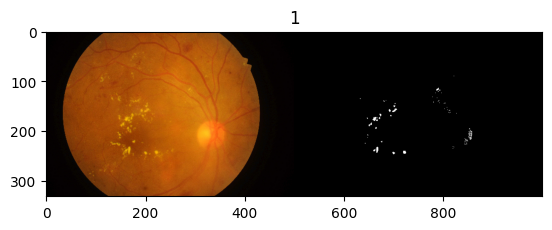

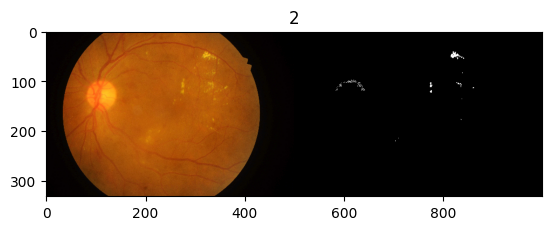

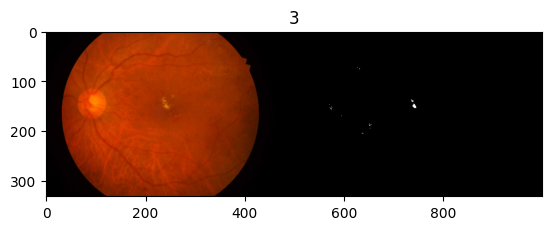

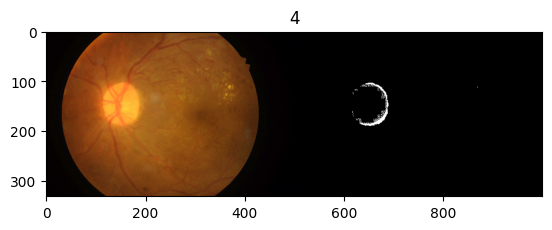

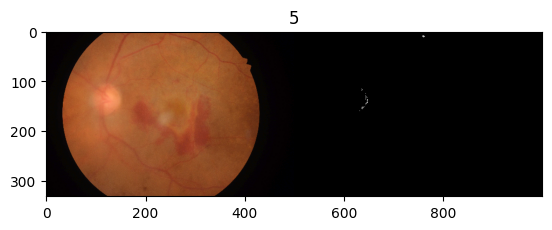

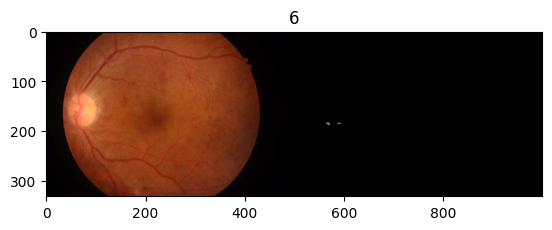

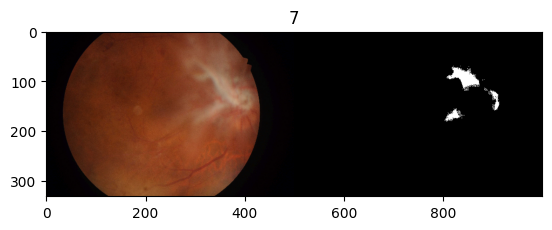

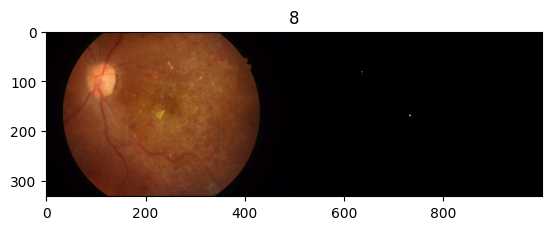

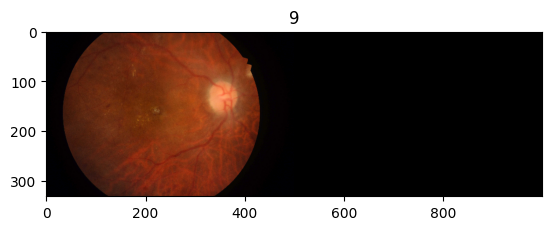

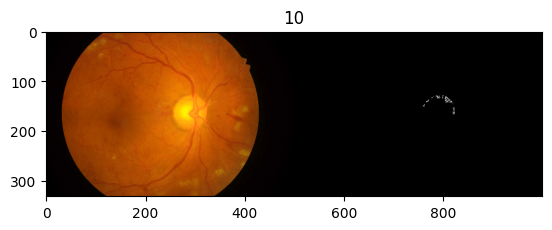

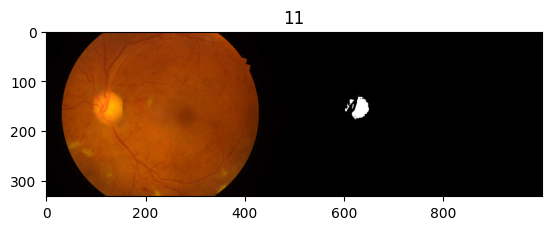

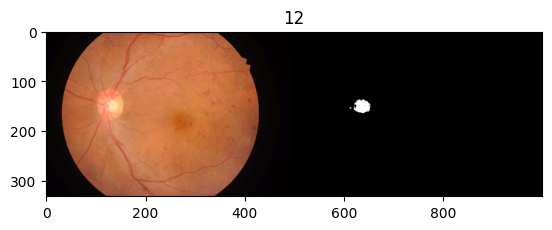

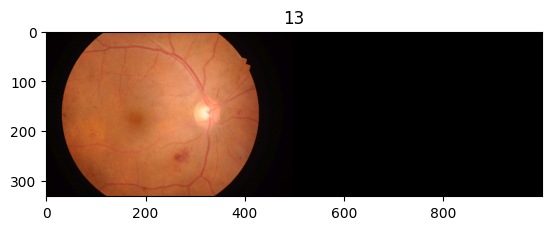

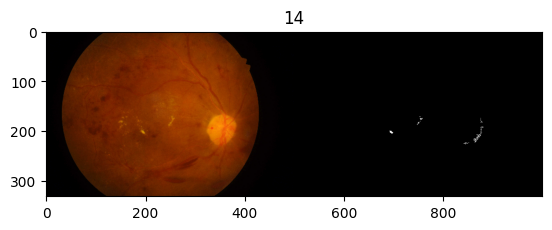

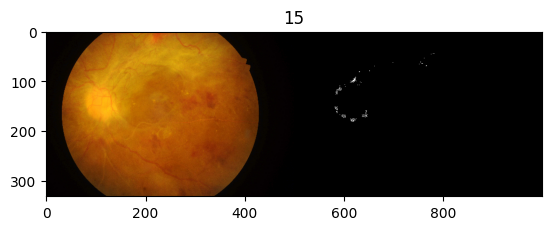

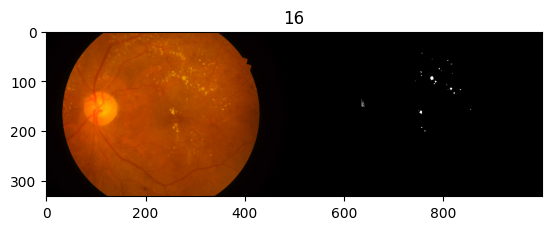

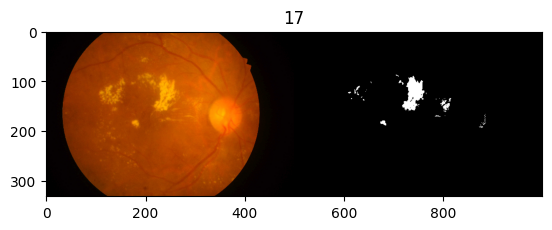

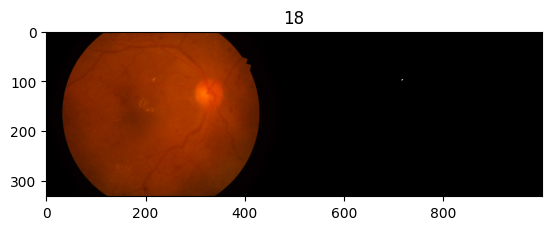

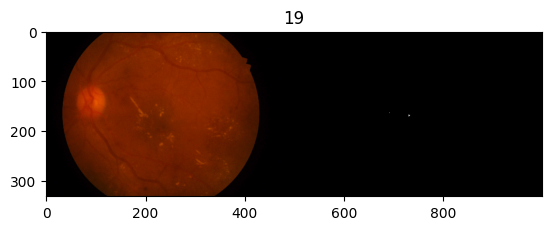

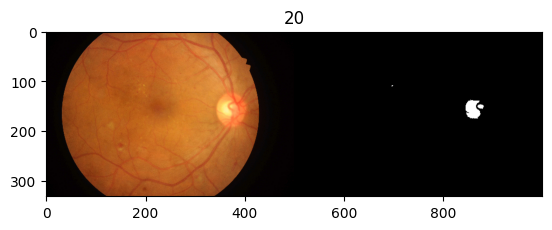

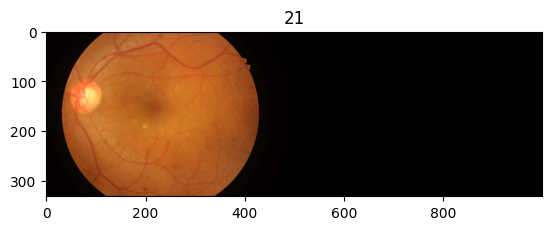

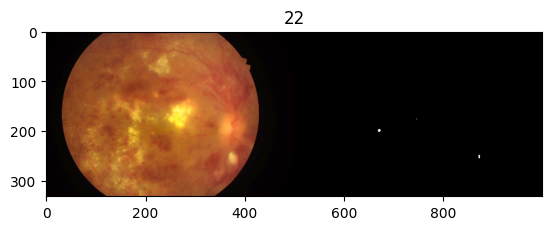

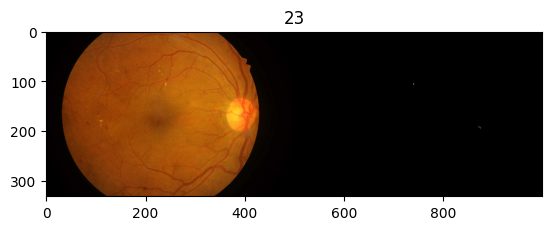

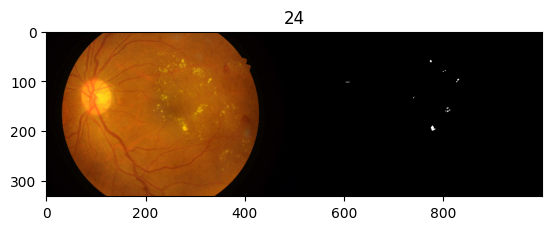

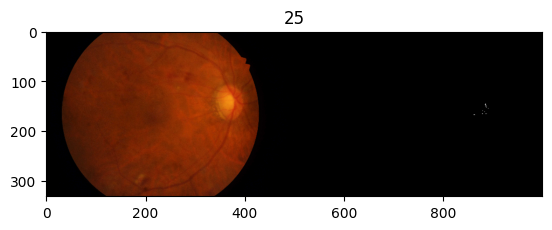

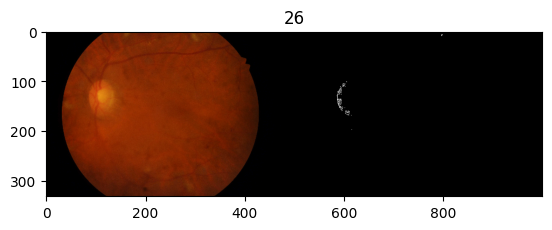

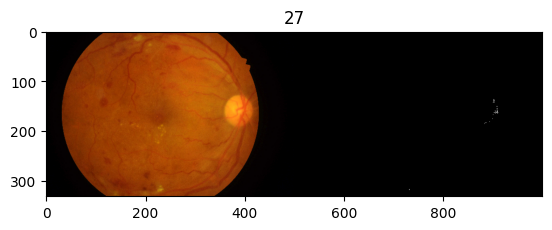

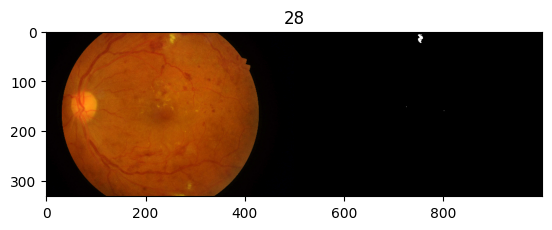

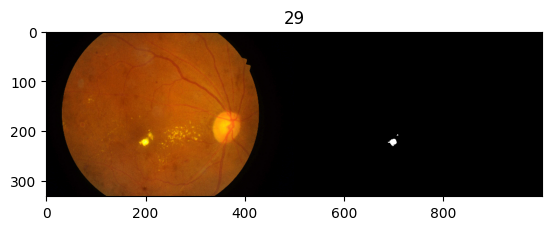

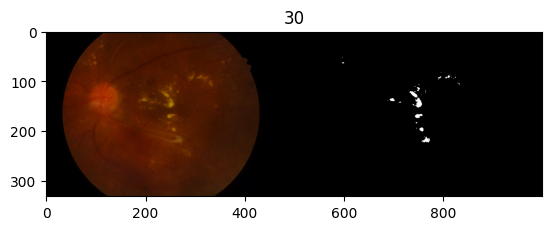

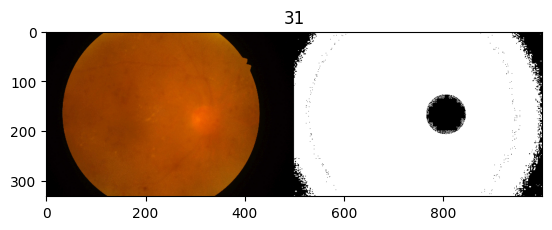

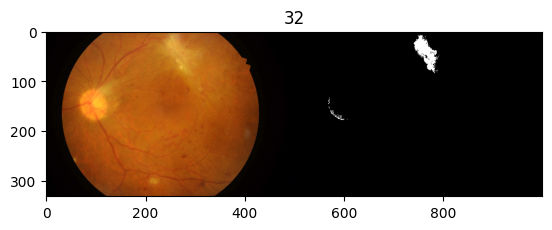

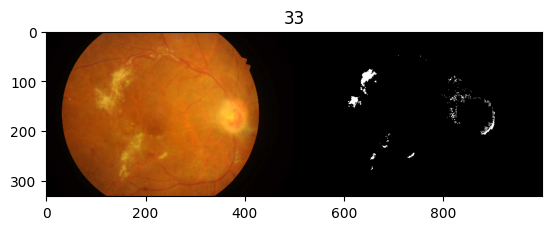

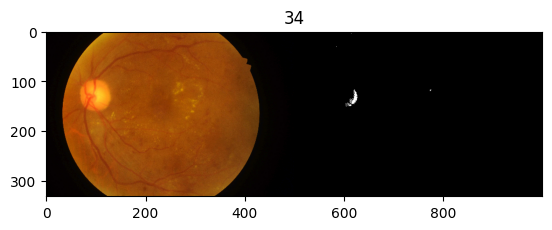

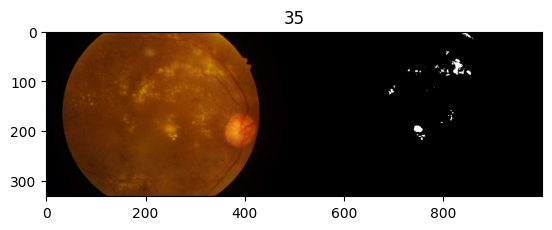

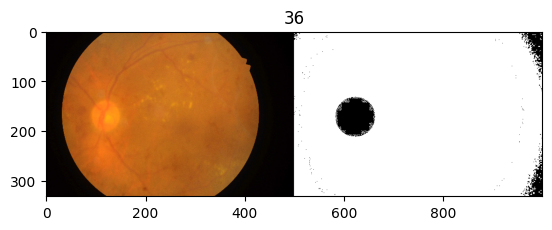

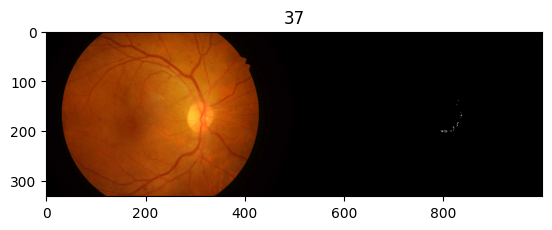

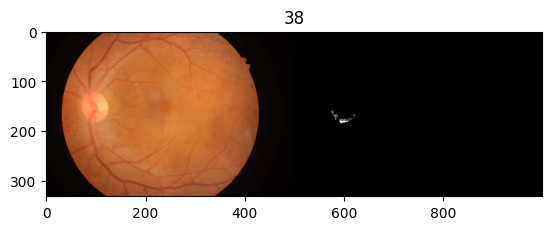

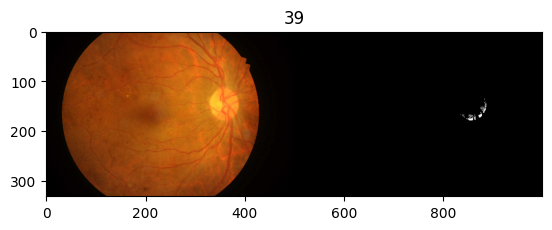

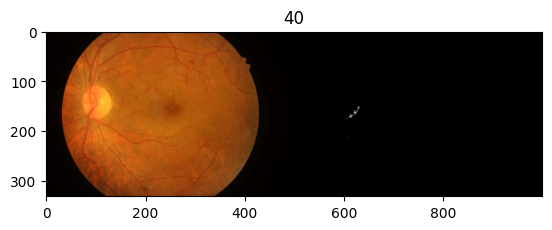

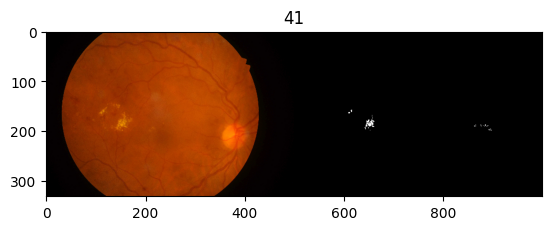

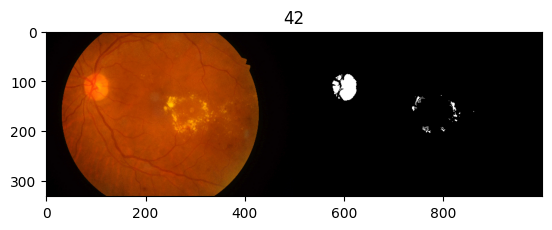

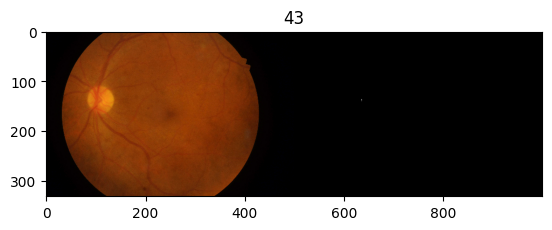

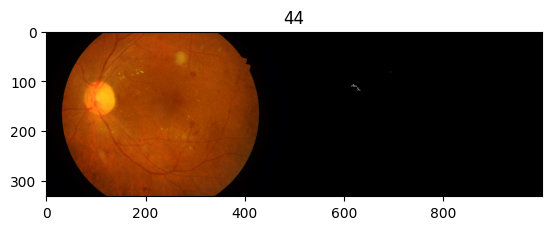

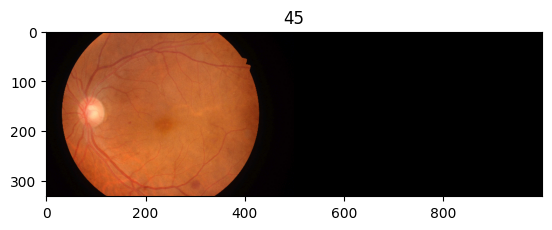

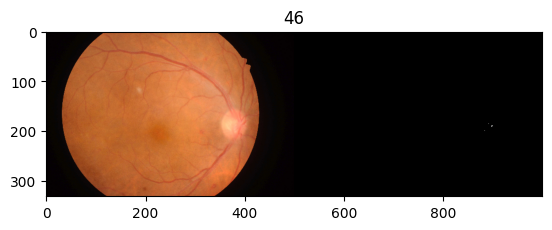

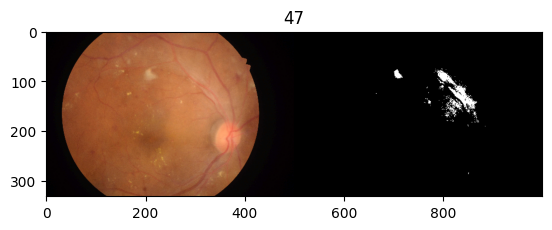

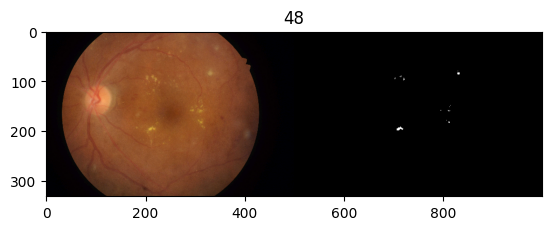

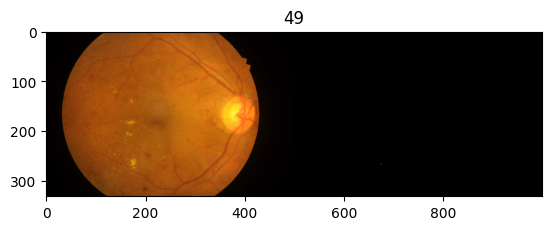

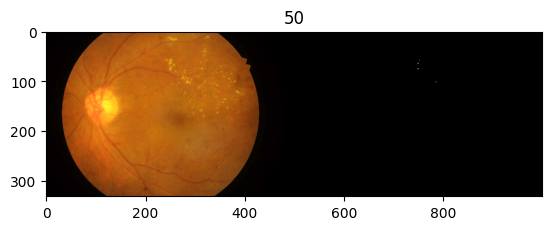

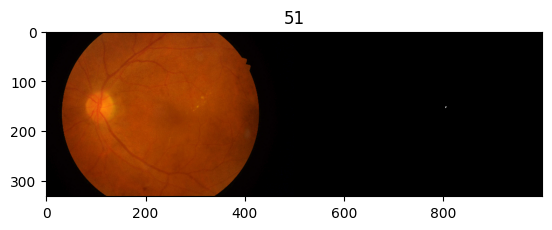

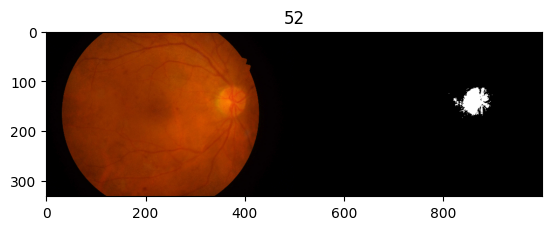

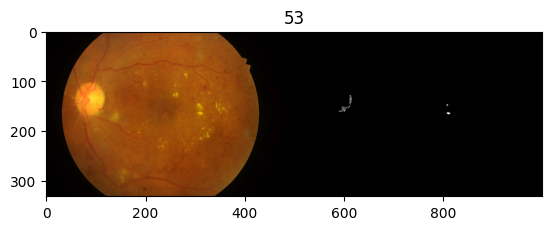

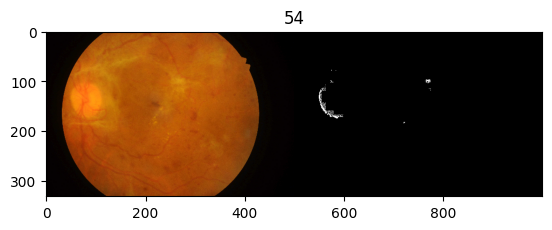

In [ ]:
#Detection of Exudates

acc = []
spcf = []
sens = []
f1_sc = []
i = 0
count = 0
img_num = 1
for img_num in range(1, 55):


  print("Image Number: ", img_num)

  if (img_num<10):
    str_num = "0" + str(img_num)
  else:
    str_num = str(img_num)
  file_path = save_path + str_num +'.jpg'
  img_mark = cv.imread(file_path, -1)



  # Read the image from file
  img = getImage(img_num)
  img = imgResize(img)


  # Splitting channels
  _, img_gc, _ = cv.split(img)


  # Large Exudates
  clus_seg = kmeansclust(img, 8, 5, 20, 0.69, use = 'EX')
  clus_seg = cv.cvtColor(clus_seg, cv.COLOR_BGR2GRAY)
  unique, counts = np.unique(clus_seg, return_counts=True)
  _,kthm = cv.threshold(clus_seg, np.max(unique)-1, 255, cv.THRESH_BINARY)


  # Small Exudates
  edges = cannyEdges(img_gc, 70, 120)
  img_cnt = cv.dilate(edges, cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)))
  img_clean = getContours1(img_cnt, img_gc, 15)
  img_clean = cv.erode(img_clean, cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)), iterations=1)
  img_clean = cv.dilate(img_clean, cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)), iterations = 2)
  max_intsy = np.max(img_clean.flatten())
  img_clean[img_clean>=max_intsy] = 255
  img_clean[img_clean<max_intsy] = 0
  _, img_clean = cv.threshold(img_clean, 173, 255, cv.THRESH_BINARY)


  img_final = cv.bitwise_or(kthm, img_clean)

  #Masking Optic Disc
  img_final[img_mark==0] = 0

  plt.figure(img_num)
  plt.title(img_num)
  plt.imshow(np.hstack([cv.cvtColor(img, cv.COLOR_RGB2BGR), cv.cvtColor(img_final, cv.COLOR_GRAY2BGR)]))